In [1]:
import os
import sys
import torch
import h5py
import wandb
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from omegaconf import OmegaConf
from matplotlib import cm, colors
from wandb.apis.public.runs import Runs, Run
from wandb.apis.public.artifacts import RunArtifacts

In [2]:
def get_model(run: Run, api: wandb.Api) -> str:
    model_path = Path(f"../pretrained_models/{run.id}/ema_model.pth").resolve()
    if not os.path.isfile(model_path):
        arts = RunArtifacts(client=api.client, run=run)
        _ = arts[0].download(root=f"../pretrained_models/{run.id}/")
    return model_path

def plot_M_thin_film2(
    m: np.ndarray,
    res: list[int],
    ax: plt.Axes,
    title: str | None = None,
    scale: float | None = None,
    width: float = 0.002,
    headwidth: float = 3,
    headlength: float = 5,
) -> None:
    '''
    Rework of plot_M_thin_film from magtense.utils to support subplots
    '''
    m = np.permute_dims(m, (1, 2, 0))  # CHW -> HWC
    k = np.moveaxis(m.reshape(res[1], res[0], res[2], 3).swapaxes(0, 1), -1, 0)[
        :, :, :, 0
    ]

    ax.clear()
    ax.quiver(
        k[0].T + 1e-20,
        k[1].T + 1e-20,
        pivot="mid",
        scale=scale,
        width=width,
        headwidth=headwidth,
        headlength=headlength,
    )

    nz = colors.Normalize(0.0, 2 * np.pi)
    clr = np.swapaxes(cm.hsv(nz(np.arctan2(k[1], k[0]) + np.pi)), 0, 1)
    ax.imshow(clr, interpolation="bicubic")

    ax.axis("scaled")
    #ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if title:
        ax.set_title(title)

In [3]:
API = wandb.Api()
wandb_cfg = OmegaConf.load("../conf/train.yaml").wandb

filters = {}#{"job_type": "train"} #{"tags": "fine-tune"}

runs = Runs(
    client=API.client,
    entity=wandb_cfg.entity,
    project=wandb_cfg.project,
    filters=filters
)

for i, run in enumerate(runs):
    print(f"Index: {i} - Run ID: {run.id}, Name: {run.name}")

Index: 0 - Run ID: jjj9pelv, Name: heat-logt/joint/unet-v2
Index: 1 - Run ID: 0pp5ahlc, Name: heat-logt/joint/unet-v2/fine-tune
Index: 2 - Run ID: 7revrf5r, Name: heat-no-cond/joint/unet-small
Index: 3 - Run ID: 1ml9aurp, Name: heat-lineart/joint/unet-v2
Index: 4 - Run ID: qbd7omen, Name: heat-lineart/joint/unet-v2/fine-tune
Index: 5 - Run ID: s42g9h6h, Name: heat_no_cond_test/dataset
Index: 6 - Run ID: xo3rg6u8, Name: heat-no-cond/joint/unet-small/test
Index: 7 - Run ID: s6svnr60, Name: heat-no-cond/joint/unet-small/test
Index: 8 - Run ID: 6usadlpw, Name: heat-logt/joint/unet-v2/test
Index: 9 - Run ID: 8dp00llj, Name: heat-no-time/joint/unet-small
Index: 10 - Run ID: hsjrwptv, Name: heat-no-time/joint/unet-small/test
Index: 11 - Run ID: beuvkdus, Name: heat-no-time/joint/unet-v2
Index: 12 - Run ID: ehi00g22, Name: heat-no-time/joint/unet-v2/test
Index: 13 - Run ID: 5gf2x0m8, Name: llg-no-time/joint/unet-v2
Index: 14 - Run ID: x1c1vdaz, Name: heat-test-datasets/dataset
Index: 15 - Run 

In [5]:
run_idx = 15
run_cfg = OmegaConf.create(runs[run_idx].config)

model_path = Path("/home/s204790/dynamical-pde-diffusion/logs/hydra/2025-12-05_12-45-38/checkpoints/ema_model_best.pth")  #get_model(runs[run_idx], API)
print(f"Model path: {model_path}")

edm = dpde.utils.get_net_from_config(run_cfg)
edm.load_state_dict(torch.load(model_path, weights_only=True))

Model path: /home/s204790/dynamical-pde-diffusion/logs/hydra/2025-12-05_12-45-38/checkpoints/ema_model_best.pth


<All keys matched successfully>

In [6]:
root_dir = dpde.utils.get_repo_root()
data_dir = root_dir / "data" 

In [7]:
with h5py.File(data_dir / "llg_test2.hdf5", "r") as f:
    data = f["U"][:]
    labels = f["labels"][:]
    t_steps = f["t_steps"][:]
    attrs = dict(f.attrs)
res = attrs["res"]

In [8]:
print(f"Data shape: {data.shape}") 
print(f"Labels shape: {labels.shape}")
print(f"time steps: {t_steps}")

Data shape: (200, 3, 64, 16, 38)
Labels shape: (200, 3)
time steps: [0.00e+00 6.00e-11 1.20e-10 1.80e-10 2.40e-10 3.00e-10 3.60e-10 4.20e-10
 4.80e-10 5.40e-10 6.00e-10 6.60e-10 7.20e-10 7.80e-10 8.40e-10 9.00e-10
 9.60e-10 1.02e-09 1.08e-09 1.14e-09 1.20e-09 1.26e-09 1.32e-09 1.38e-09
 1.44e-09 1.50e-09 1.56e-09 1.62e-09 1.68e-09 1.74e-09 1.80e-09 1.86e-09
 1.92e-09 1.98e-09 2.04e-09 2.10e-09 2.16e-09 2.22e-09]


In [11]:
dx = attrs["dx"]
dy = attrs["dy"]
T = attrs["T"]
res = attrs["res"]
grid_size = attrs["grid_size"]

In [15]:
idx = 30   # which sample to visualize
t0_idx = 0
tf_idx = 20  # which time step to visualize

t = t_steps[tf_idx].item() - t_steps[t0_idx].item()
lbl = labels[idx, :]
a = data[idx, ... , t0_idx]  # (S, S)
u = data[idx, ... , tf_idx]  # (S, S)

a.shape, u.shape

((3, 64, 16), (3, 64, 16))

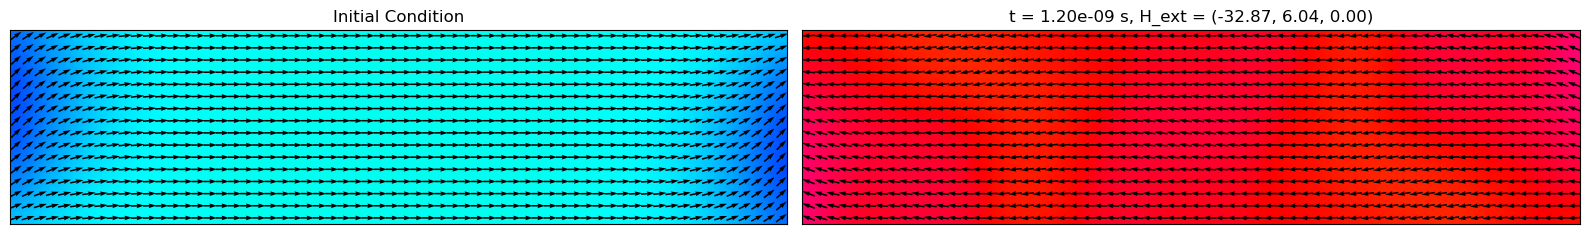

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(a, res=res, ax=axs[0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
plt.tight_layout()
plt.show()

In [17]:
obs_a = torch.tensor(a)
obs_u = torch.tensor(u)
OBS = torch.stack([obs_a, obs_u], dim=0)

ch_a = 3 if run_cfg.dataset.method == "joint" else 0

sample_shape = (16, 6, 64, 16)

generator = torch.Generator().manual_seed(0)

interior_a = 0.0
interior_u = 0.0
boundary_a = 0.0
boundary_u = 0.0
same_boundary = False
boundary_obs_a = dpde.model_testing.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_a)
if same_boundary:
    boundary_obs_u = boundary_obs_a[:]
else:
    boundary_obs_u = dpde.model_testing.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_u)
interior_obs_a = dpde.model_testing.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_a)
interior_obs_u = dpde.model_testing.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_u)

mask_a = dpde.model_testing.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.model_testing.combine_masks(boundary_obs_u, interior_obs_u)

In [ ]:
sampler = dpde.sampling.JointSampler(
    net=edm,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    sample_shape=(64, 16),
    num_channels=6 if run_cfg.dataset.method == "joint" else 3,
    num_samples=16,
    ch_a=3 if run_cfg.dataset.method == "joint" else 0,
    loss_fn=dpde.sampling.pde_losses.llg_loss2,
    loss_kwargs={},
    num_steps=50,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
)

In [22]:
zeta_a = 10.0
zeta_u = 10.0
zeta_pde = 0.5

num_steps = 50

use_t_cond = True
if use_t_cond:
    t_cond = torch.full((sample_shape[0], 1), t)

lbls = torch.tensor(lbl).unsqueeze(0).repeat(sample_shape[0], 1)
if use_t_cond:
    lbls = torch.cat([t_cond, lbls], dim=-1)

with dpde.sampling.sampling_context(sampler):
    samples, losses = sampler.sample(
        labels=lbls,
        obs_a=obs_a,
        obs_u=obs_u,
        mask_a=mask_a,
        mask_u=mask_u,
        zeta_a=zeta_a,
        zeta_u=zeta_u,
        zeta_pde=zeta_pde,
        num_steps=num_steps,
        return_losses=True,
    )
print(f"Final total loss: {losses[-1, 3]:.4f}")
samples = samples.numpy()

legend = ['obs_u', 'pde', 'obs weight drop ($\\times 0.1$)']
if run_cfg.dataset.method == "joint":
    legend = ['obs_a'] + legend

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :-1])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, -1])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(legend)
plt.show()

TypeError: llg_loss2() got an unexpected keyword argument 'dx'

In [43]:
rng = np.random.default_rng()

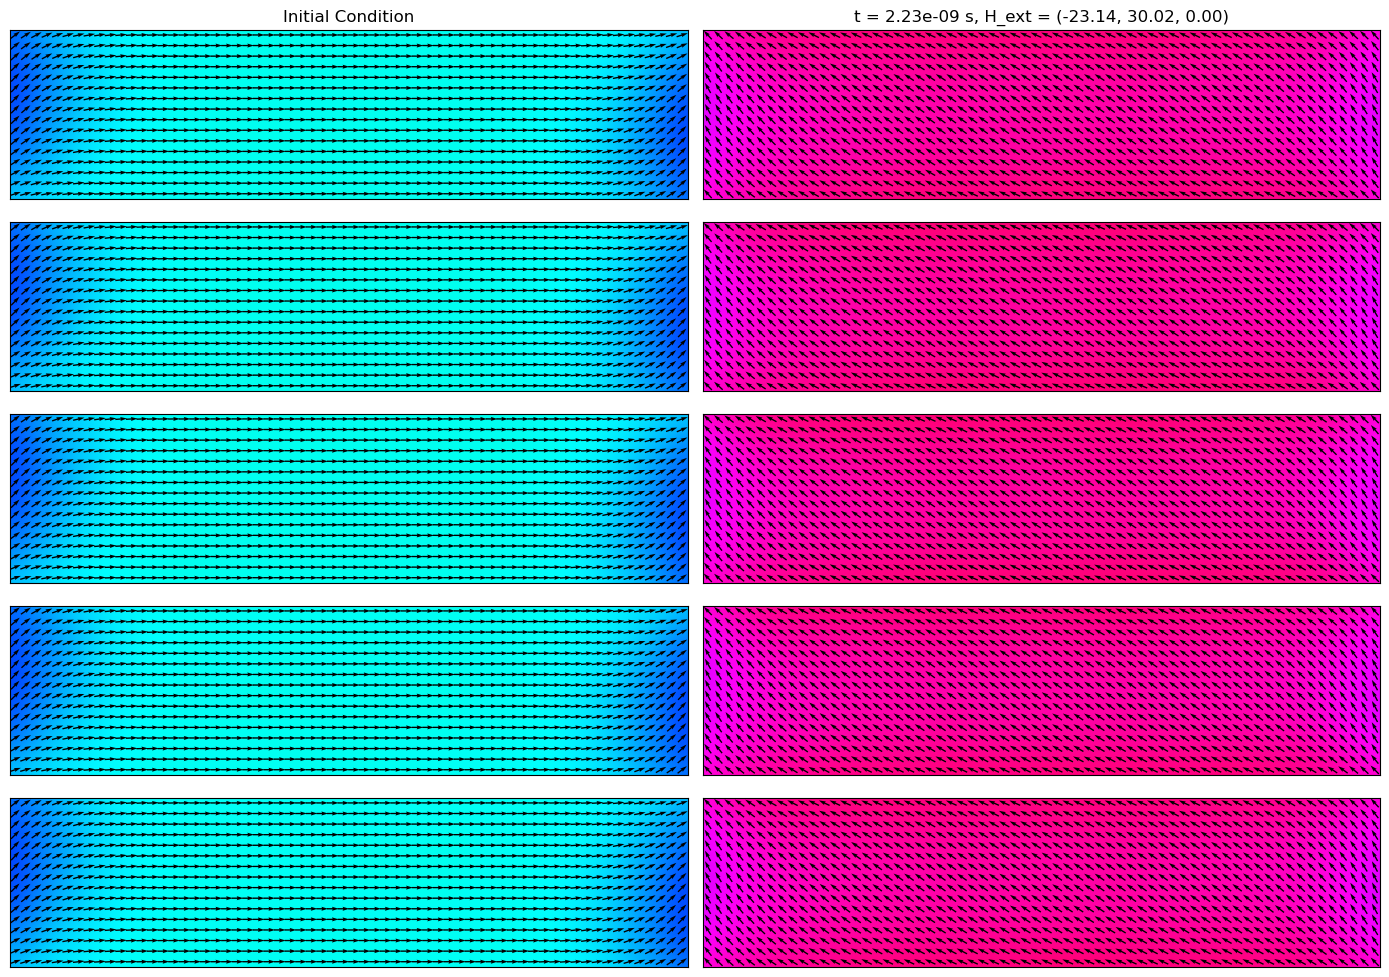

In [44]:
num_samples_plot = 4
fig, axs = plt.subplots(num_samples_plot + 1, 2, figsize=(14, 2 * (num_samples_plot + 1)))

plot_M_thin_film2(a, res=res, ax=axs[0, 0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[0, 1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
for i in range(num_samples_plot):
    idx = rng.integers(0, samples.shape[0])
    plot_M_thin_film2(samples[idx, :ch_a, ...], res=res, ax=axs[i + 1, 0])
    plot_M_thin_film2(samples[idx, ch_a:, ...], res=res, ax=axs[i + 1, 1])
plt.tight_layout()
plt.show()

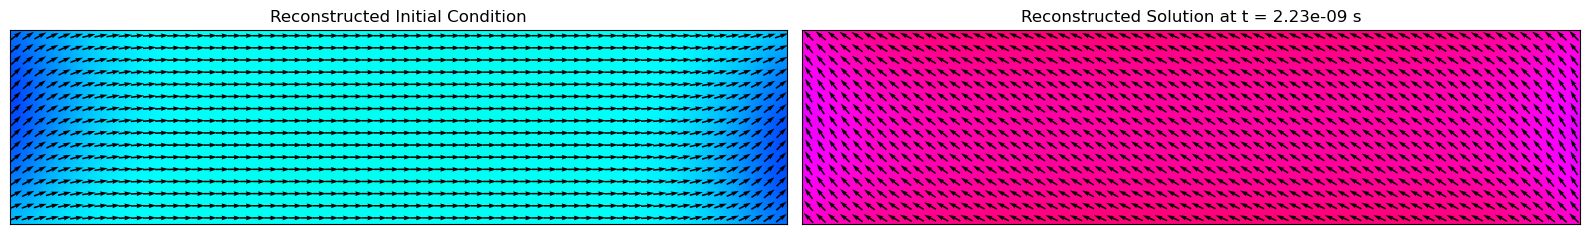

In [45]:
average_a = samples[:, :ch_a, ...].mean(axis=0)
average_u = samples[:, ch_a:, ...].mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(average_a, res=res, ax=axs[0], title="Reconstructed Initial Condition")
plot_M_thin_film2(average_u, res=res, ax=axs[1], title=f"Reconstructed Solution at t = {t:.2e} s")
plt.tight_layout()
plt.show()

In [46]:
samples.shape

(16, 6, 64, 16)

In [47]:
std_u = samples[:, ch_a:, ...].std(axis=(0)).mean(axis=0)

In [48]:
std_u.shape

(64, 16)

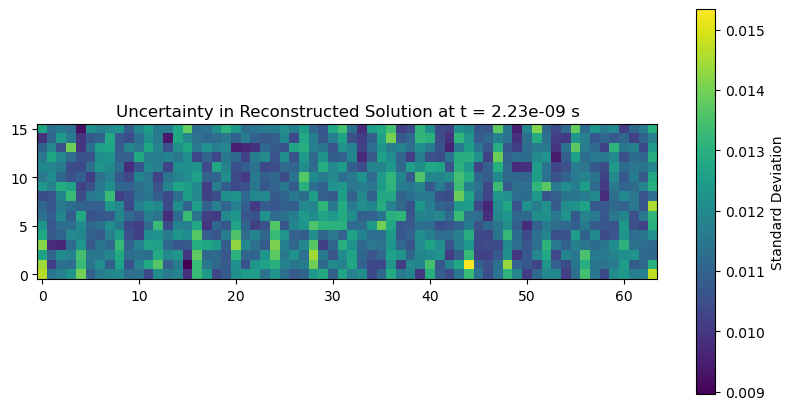

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(std_u.T, cmap='viridis', origin='lower')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Standard Deviation')
ax.set_title('Uncertainty in Reconstructed Solution at t = {:.2e} s'.format(t))
plt.show()